# Trying out constraints

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps_ai
import aps_ai.beamline34IDC.optimization.common as opt_common
import aps_ai.beamline34IDC.optimization.movers as movers
import IPython
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps_ai.beamline34IDC.optimization.optuna_botorch import OptunaOptimizer
from aps_ai.common.util import clean_up
from aps_ai.common.util.shadow.common import (
    get_shadow_beam_spatial_distribution,
    load_shadow_beam,
    plot_shadow_beam_spatial_distribution,
)
from tqdm import tqdm

%matplotlib inline

In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

58138


In [4]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test


In [5]:
root_dir = Path(aps_ai.__path__[0]).parents[0]
base_dir = root_dir / 'work_directory'
orig_work_dir = base_dir /'34-ID'
temp_work_dir = base_dir / f'tmp_work_dir_34-ID-{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [6]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [7]:
os.chdir(temp_work_dir)

In [11]:
input_beam_path = "primary_optics_system_beam.dat"

In [8]:
move_motors_ranges = {'hkb_1': [-50, 50], 
                      'vkb_1': [-50, 50],
                      'hkb_2': [-50, 50],
                      'vkb_2': [-50, 50],
                      'hkb_3': [-0.05, 0.05],
                      'vkb_3': [-0.05, 0.05],
                      'hkb_4': [-50, 50], 
                      'vkb_4': [-50, 50]}
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [12]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

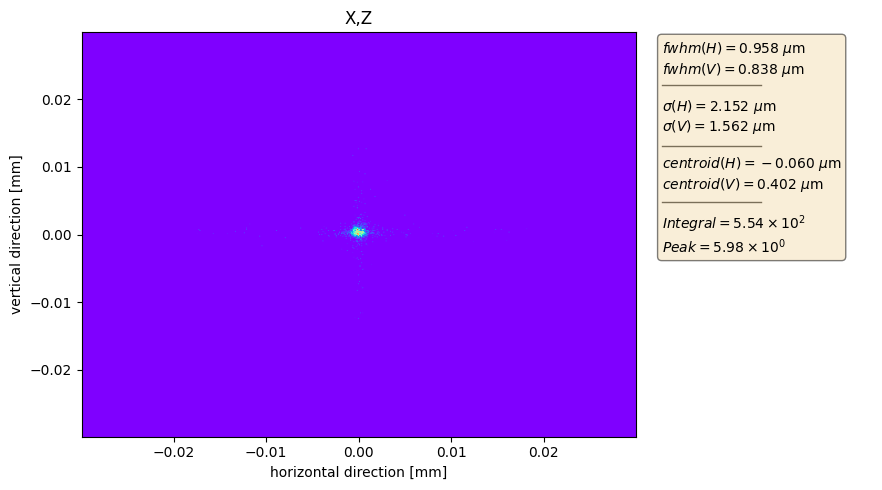

In [14]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.03, 0.03],
    yrange=[-0.03, 0.03],
    nbins=501,
)

In [15]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [20]:
centroid_ground, *_ = opt_common.get_centroid_distance(
    photon_beam=beam,
    xrange=[-0.03, 0.03],
    yrange=[-0.03, 0.03],
    nbins=501,
    random_seed=DEFAULT_RANDOM_SEED,
)
sigma_ground, *_ = opt_common.get_sigma(
    photon_beam=beam,
    xrange=[-0.03, 0.03],
    yrange=[-0.03, 0.03],
    nbins=501,
    random_seed=DEFAULT_RANDOM_SEED,
)
centroid_ground, sigma_ground

(0.00040674697571959175, 0.0026591191104129806)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

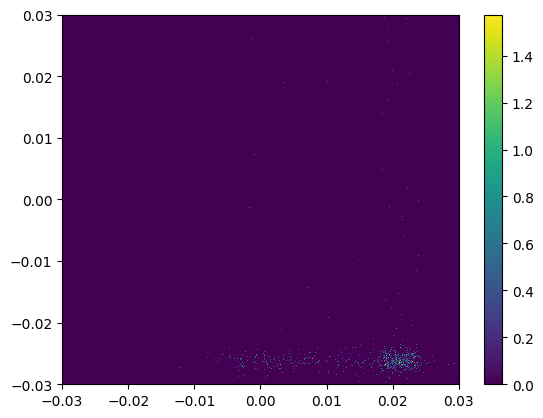

In [21]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.03, 0.03],
    yrange=[-0.03, 0.03],
    integral_threshold=300,
    nbins=501,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [35]:
hist.data_2D.sum()

514.0480655710743

In [115]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

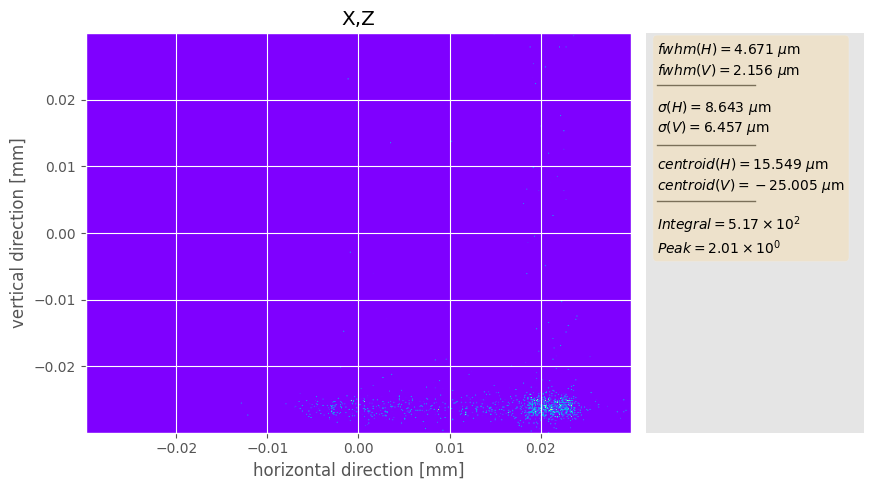

In [116]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.03, 0.03],
    yrange=[-0.03, 0.03],
    nbins=501,
)

In [117]:
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(move_motors_ranges.keys()),
    random_seed=DEFAULT_RANDOM_SEED,
    loss_parameters=["centroid", "sigma"],
    use_gaussian_fit=False,
    multi_objective_optimization=True,
    camera_xrange=[-0.03, 0.03],
    camera_yrange=[-0.03, 0.03],
    camera_nbins=501,
)
# opt_trial.motor_ranges = centroid_ranges

In [118]:
constraints = {"sum_intensity": 500, "centroid":5e-3, "sigma":5e-3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=100,
    moo_thresholds={"centroid": 1e-3, "sigma": 3e-3},
    constraints=constraints,
)

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:300: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler(
[I 2022-10-18 01:07:51,308] A new study created in memory with name: no-name-fed456e5-5128-4402-9989-71be423e3ceb


In [119]:
opt_trial.trials(100, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:423: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

In [120]:
opt_trial.study.best_trials

[FrozenTrial(number=18, values=[0.0059463758636885515, 0.003307021447428301], datetime_start=datetime.datetime(2022, 10, 18, 1, 8, 16, 160737), datetime_complete=datetime.datetime(2022, 10, 18, 1, 8, 17, 864960), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.0465, 'vkb_3': 0.0305, 'hkb_4': 18.400000000000006, 'vkb_4': 13.400000000000006}, distributions={'hkb_1': FloatDistribution(high=49.9999, log=False, low=-50.0, step=0.0001), 'vkb_1': FloatDistribution(high=49.9999, log=False, low=-50.0, step=0.0001), 'hkb_2': FloatDistribution(high=49.9999, log=False, low=-50.0, step=0.0001), 'vkb_2': FloatDistribution(high=49.9999, log=False, low=-50.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175), 'vkb_3': FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175), 'hkb_4': FloatDistribution(high=49.9, log=False, low=-50.0, step=0.1), 'vkb_4': FloatDistribution(high=49.9, log=False, low=-50.0, step=0.1)}, user_at

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_84112/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


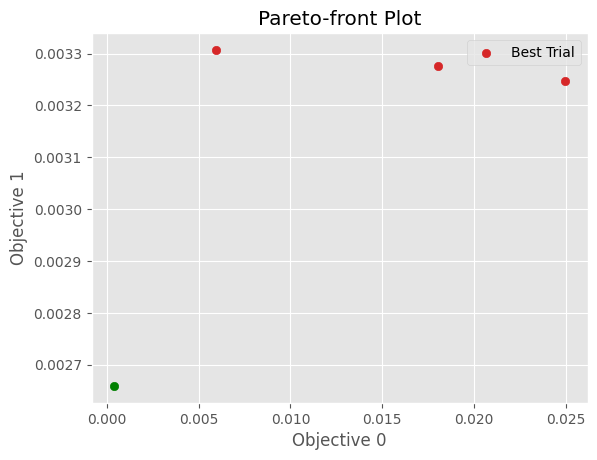

In [121]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [122]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-10.836680703080072 0.797465292700745
-9.73837650813747 11.974823431008433
-9.421202359530156 19.029819921189212


[0.0059463758636885515, 0.003307021447428301] 0.797465292700745


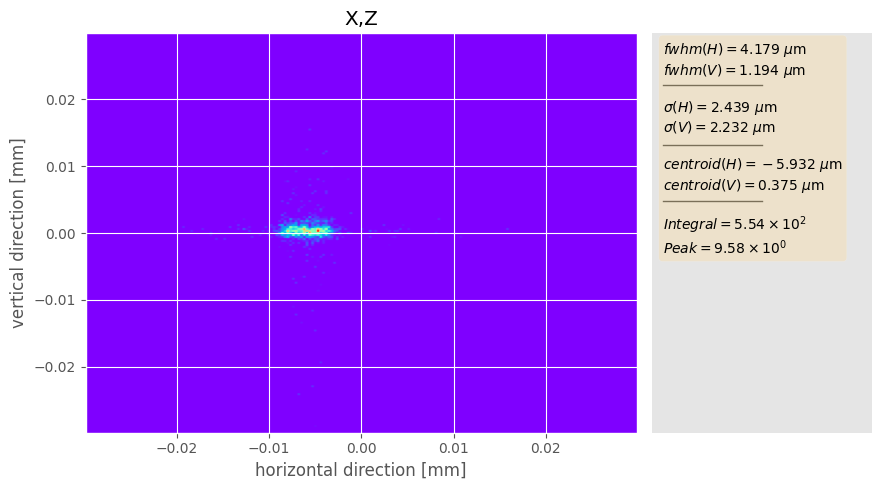

[0.018007376454637108, 0.0032751136567676763] 11.974823431008433


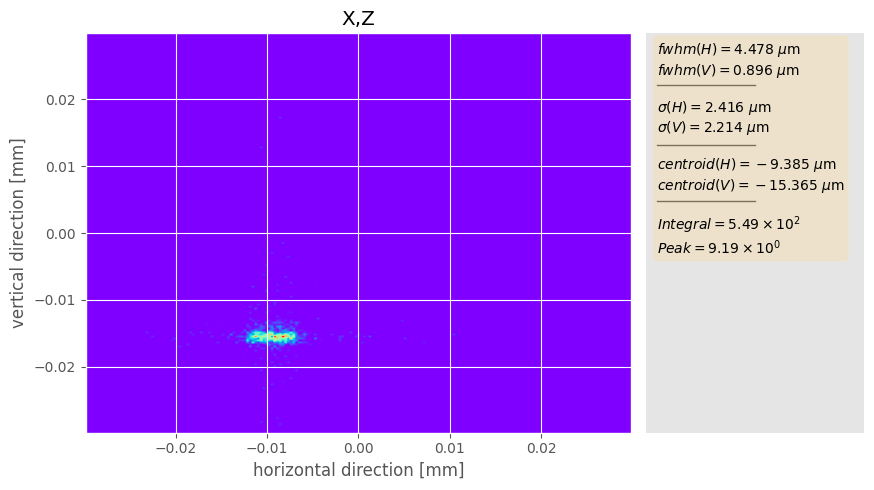

[0.024936245994463, 0.003247825810160928] 19.029819921189212


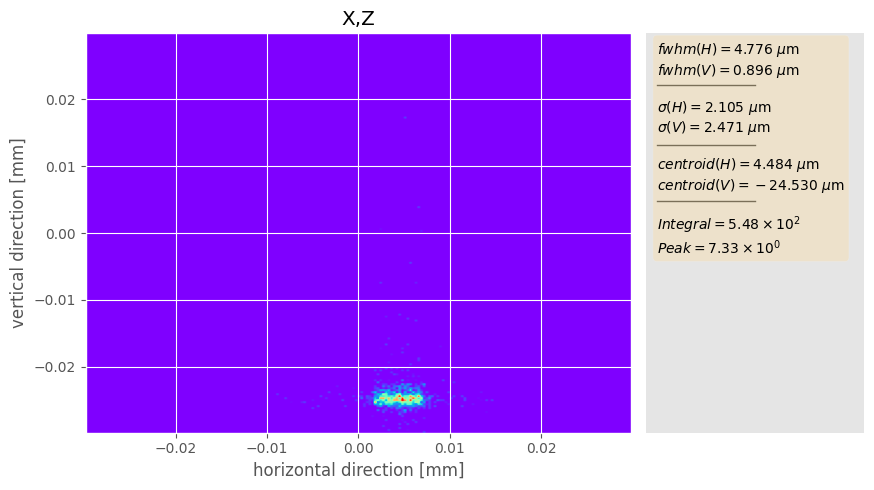

In [123]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [124]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:05,554] Trial 100 finished with values: [0.022104797227957867, 0.005975539286045464] and parameters: {'hkb_1': -21.397299999999998, 'vkb_1': -33.5333, 'hkb_2': -1.0784999999999982, 'vkb_2': -8.2393, 'hkb_3': -0.044750000000000005, 'vkb_3': 0.0165, 'hkb_4': 33.400000000000006, 'vkb_4': 33.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:12:09,824] Trial 101 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:12:14,123] Trial 102 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:17,408] Trial 103 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:21,217] Trial 104 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:25,568] Trial 105 finished with values: [0.011163459189493184, 0.003809542778695576] and parameters: {'hkb_1': 27.1053, 'vkb_1': -9.637699999999995, 'hkb_2': -36.517399999999995, 'vkb_2': 48.8151, 'hkb_3': 0.011249999999999996, 'vkb_3': -0.006249999999999999, 'hkb_4': 21.0, 'vkb_4': 21.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:30,288] Trial 106 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:34,156] Trial 107 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:12:38,502] Trial 108 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:43,405] Trial 109 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:48,290] Trial 110 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:51,836] Trial 111 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:12:56,074] Trial 112 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:13:00,616] Trial 113 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:13:04,971] Trial 114 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:13:09,263] Trial 115 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:13:13,709] Trial 116 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:13:17,098] Trial 117 finished with values: [0.009765968407891167, 0.01777006641505395] and parameters: {'hkb_1': -34.9441, 'vkb_1': 4.6810000000000045, 'hkb_2': -32.085300000000004, 'vkb_2': -6.966099999999997, 'hkb_3': -0.044750000000000005, 'vkb_3': 0.025249999999999995, 'hkb_4': 23.5, 'vkb_4': 43.900000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:13:21,400] Trial 118 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:13:26,258] Trial 119 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:13:30,622] Trial 120 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:13:33,410] Trial 121 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:13:37,513] Trial 122 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:13:41,462] Trial 123 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:13:45,182] Trial 124 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:13:49,940] Trial 125 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:13:53,810] Trial 126 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:13:56,988] Trial 127 finished with values: [0.00526406072811655, 0.0036427249439319196] and parameters: {'hkb_1': -40.5275, 'vkb_1': 44.1876, 'hkb_2': -11.262299999999996, 'vkb_2': 9.010200000000005, 'hkb_3': -0.008, 'vkb_3': 0.011249999999999996, 'hkb_4': 24.900000000000006, 'vkb_4': 26.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:13:59,755] Trial 128 finished with values: [0.01930538010946522, 0.00921171036933352] and parameters: {'hkb_1': -25.918599999999998, 'vkb_1': 17.08590000000001, 'hkb_2': 0.2938000000000045, 'vkb_2': 2.940100000000001, 'hkb_3': -0.023750000000000004, 'vkb_3': 0.011249999999999996, 'hkb_4': 40.2, 'vkb_4': 31.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:03,751] Trial 129 finished with values: [0.019548395430640613, 0.004619938912495845] and parameters: {'hkb_1': -18.814799999999998, 'vkb_1': 44.4627, 'hkb_2': 33.791700000000006, 'vkb_2': -45.4824, 'hkb_3': 0.011249999999999996, 'vkb_3': -0.018500000000000003, 'hkb_4': 42.60000000000001, 'vkb_4': 16.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:07,723] Trial 130 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:11,304] Trial 131 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:14:14,673] Trial 132 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:18,938] Trial 133 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:14:22,509] Trial 134 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:14:27,190] Trial 135 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:14:31,302] Trial 136 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:35,744] Trial 137 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:38,599] Trial 138 finished with values: [0.013782617927305018, 0.01366791005969648] and parameters: {'hkb_1': -35.2337, 'vkb_1': 2.077300000000001, 'hkb_2': -6.615699999999997, 'vkb_2': 7.1052000000000035, 'hkb_3': -0.015, 'vkb_3': 0.011249999999999996, 'hkb_4': 35.10000000000001, 'vkb_4': -5.899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:42,998] Trial 139 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:46,052] Trial 140 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:14:50,472] Trial 141 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:14:53,066] Trial 142 finished with values: [0.009090031122600583, 0.0033765786762142594] and parameters: {'hkb_1': -42.4223, 'vkb_1': -42.7542, 'hkb_2': -37.6381, 'vkb_2': -46.8685, 'hkb_3': -0.008, 'vkb_3': 0.021750000000000005, 'hkb_4': 20.900000000000006, 'vkb_4': 9.100000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:14:57,348] Trial 143 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:15:02,538] Trial 144 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:15:06,959] Trial 145 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:15:10,297] Trial 146 finished with values: [0.013532658949768187, 0.005293513401204059] and parameters: {'hkb_1': -25.7122, 'vkb_1': -4.589599999999997, 'hkb_2': -44.8482, 'vkb_2': -6.522599999999997, 'hkb_3': -0.022000000000000002, 'vkb_3': -0.025500000000000002, 'hkb_4': 10.900000000000006, 'vkb_4': 27.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:15:14,267] Trial 147 finished with values: [0.023886701288595588, 0.01205221201517897] and parameters: {'hkb_1': 3.9155000000000015, 'vkb_1': 26.85090000000001, 'hkb_2': -28.4164, 'vkb_2': -46.0696, 'hkb_3': -0.025500000000000002, 'vkb_3': -0.004500000000000004, 'hkb_4': 20.400000000000006, 'vkb_4': -1.1999999999999957}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:15:19,358] Trial 148 finished with values: [0.01247725398851411, 0.00400614310335873] and parameters: {'hkb_1': -17.3245, 'vkb_1': 46.0963, 'hkb_2': 39.0453, 'vkb_2': -12.668799999999997, 'hkb_3': 0.01475, 'vkb_3': 0.035750000000000004, 'hkb_4': 28.400000000000006, 'vkb_4': 21.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:15:24,217] Trial 149 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:15:28,436] Trial 150 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:15:33,424] Trial 151 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:15:38,382] Trial 152 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:15:42,767] Trial 153 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:15:47,735] Trial 154 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:15:52,561] Trial 155 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:15:55,727] Trial 156 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:15:59,852] Trial 157 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:16:02,962] Trial 158 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:16:06,795] Trial 159 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:16:10,793] Trial 160 finished with values: [0.020240709634350356, 0.00453363526851012] and parameters: {'hkb_1': 38.005700000000004, 'vkb_1': -39.3576, 'hkb_2': 41.0222, 'vkb_2': -3.005199999999995, 'hkb_3': 0.0305, 'vkb_3': 0.04625, 'hkb_4': 32.7, 'vkb_4': 26.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:16:15,555] Trial 161 finished with values: [0.014890321615786007, 0.003659203159654786] and parameters: {'hkb_1': -10.393999999999998, 'vkb_1': 44.11150000000001, 'hkb_2': 36.647400000000005, 'vkb_2': -40.3708, 'hkb_3': 0.01475, 'vkb_3': 0.048, 'hkb_4': 24.0, 'vkb_4': 17.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:16:18,881] Trial 162 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:16:22,946] Trial 163 finished with values: [0.010738458940506733, 0.019643643920571198] and parameters: {'hkb_1': 27.206500000000005, 'vkb_1': 40.26740000000001, 'hkb_2': -26.8056, 'vkb_2': 37.081500000000005, 'hkb_3': 0.0305, 'vkb_3': 0.004249999999999997, 'hkb_4': -0.8999999999999986, 'vkb_4': 31.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:16:27,249] Trial 164 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:16:31,468] Trial 165 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:16:34,988] Trial 166 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:16:38,906] Trial 167 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:16:43,596] Trial 168 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:16:47,448] Trial 169 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:16:52,377] Trial 170 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:16:55,761] Trial 171 finished with values: [0.01020664828998533, 0.00353165070026785] and parameters: {'hkb_1': 12.3337, 'vkb_1': -32.3784, 'hkb_2': -12.362699999999997, 'vkb_2': 9.958400000000005, 'hkb_3': -0.008, 'vkb_3': 0.028749999999999998, 'hkb_4': 33.2, 'vkb_4': 13.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:16:59,792] Trial 172 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:04,136] Trial 173 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:08,317] Trial 174 finished with values: [0.029894379011420977, 0.003778011091018499] and parameters: {'hkb_1': -11.5578, 'vkb_1': 47.5689, 'hkb_2': -17.801699999999997, 'vkb_2': 7.403600000000004, 'hkb_3': -0.05, 'vkb_3': 0.040999999999999995, 'hkb_4': 32.10000000000001, 'vkb_4': 30.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:11,840] Trial 175 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:15,995] Trial 176 finished with values: [0.011735192367213787, 0.004832155961331601] and parameters: {'hkb_1': 31.964, 'vkb_1': 43.0338, 'hkb_2': 22.450400000000002, 'vkb_2': 21.81790000000001, 'hkb_3': 0.020000000000000004, 'vkb_3': -0.027250000000000003, 'hkb_4': 32.30000000000001, 'vkb_4': 28.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:19,844] Trial 177 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:17:25,016] Trial 178 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:17:30,090] Trial 179 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:35,205] Trial 180 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:17:39,705] Trial 181 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:43,678] Trial 182 finished with values: [0.021225654988286508, 0.004019643337667082] and parameters: {'hkb_1': 14.480199999999996, 'vkb_1': 2.9299000000000035, 'hkb_2': 40.872, 'vkb_2': -23.720699999999997, 'hkb_3': 0.028749999999999998, 'vkb_3': 0.03924999999999999, 'hkb_4': 12.600000000000001, 'vkb_4': 21.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:48,403] Trial 183 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:51,808] Trial 184 finished with values: [0.029046360416641524, 0.007981848315492734] and parameters: {'hkb_1': -4.177999999999997, 'vkb_1': 30.262600000000006, 'hkb_2': -4.663699999999999, 'vkb_2': -48.4828, 'hkb_3': 0.0024999999999999953, 'vkb_3': -0.044750000000000005, 'hkb_4': 46.80000000000001, 'vkb_4': 17.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:17:57,017] Trial 185 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:18:01,753] Trial 186 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:18:06,830] Trial 187 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:18:09,698] Trial 188 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:18:14,215] Trial 189 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:18:17,144] Trial 190 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:18:21,858] Trial 191 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:18:26,022] Trial 192 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:18:30,951] Trial 193 finished with values: [0.012469559011212937, 0.017417599330317706] and parameters: {'hkb_1': 48.151700000000005, 'vkb_1': -47.6764, 'hkb_2': 8.9388, 'vkb_2': 44.736000000000004, 'hkb_3': -0.018500000000000003, 'vkb_3': -0.0010000000000000009, 'hkb_4': 32.60000000000001, 'vkb_4': -4.599999999999994}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:18:35,341] Trial 194 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:18:39,496] Trial 195 finished with values: [0.030420587934720893, 0.0046351916986131425] and parameters: {'hkb_1': 20.80380000000001, 'vkb_1': -12.6205, 'hkb_2': 13.3752, 'vkb_2': 11.884400000000007, 'hkb_3': -0.0010000000000000009, 'vkb_3': -0.037750000000000006, 'hkb_4': 41.80000000000001, 'vkb_4': 17.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:18:44,023] Trial 196 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:18:48,013] Trial 197 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-50, 49.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:283: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys/util/oasys_util.py:292: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
[I 2022-10-18 01:18:52,377] Trial 198 pruned. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-50, 49.99990000000001] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-50, 49.9999].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

[I 2022-10-18 01:18:55,179] Trial 199 pruned. 


In [125]:
opt_trial.study.best_trials

[FrozenTrial(number=18, values=[0.0059463758636885515, 0.003307021447428301], datetime_start=datetime.datetime(2022, 10, 18, 1, 8, 16, 160737), datetime_complete=datetime.datetime(2022, 10, 18, 1, 8, 17, 864960), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': -0.0465, 'vkb_3': 0.0305, 'hkb_4': 18.400000000000006, 'vkb_4': 13.400000000000006}, distributions={'hkb_1': FloatDistribution(high=49.9999, log=False, low=-50.0, step=0.0001), 'vkb_1': FloatDistribution(high=49.9999, log=False, low=-50.0, step=0.0001), 'hkb_2': FloatDistribution(high=49.9999, log=False, low=-50.0, step=0.0001), 'vkb_2': FloatDistribution(high=49.9999, log=False, low=-50.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175), 'vkb_3': FloatDistribution(high=0.04975, log=False, low=-0.05, step=0.00175), 'hkb_4': FloatDistribution(high=49.9, log=False, low=-50.0, step=0.1), 'vkb_4': FloatDistribution(high=49.9, log=False, low=-50.0, step=0.1)}, user_at

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_84112/3803381583.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


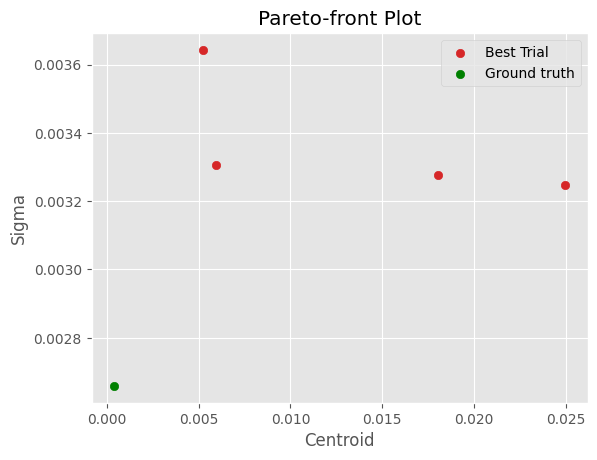

In [126]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [127]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-10.836680703080072
-9.73837650813747
-9.421202359530156
-10.861875814961966


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

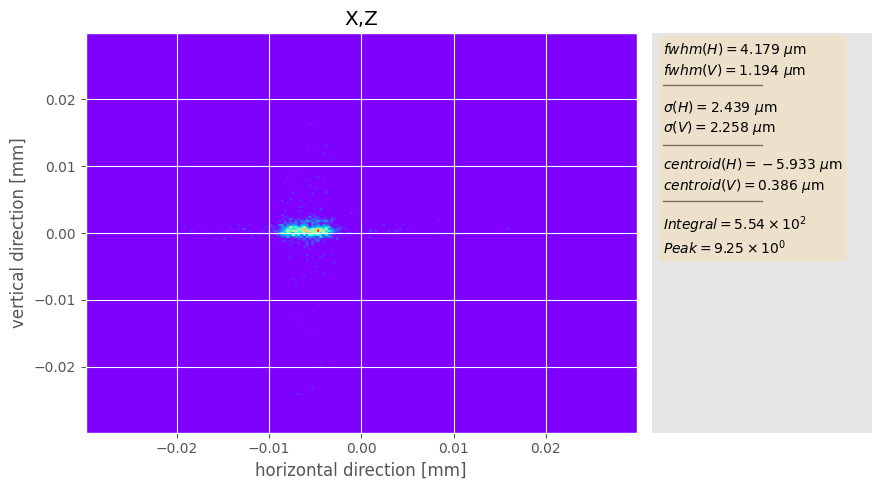

[0.018007376454637108, 0.0032751136567676763] 11.974823431008433
BeamParameterOutput(parameter_value=0.01761239796141448, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f96c3ff4c40>, hist=<aps_ai.common.util.common.Histogram object at 0x7f96c1ae6370>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7f96c1ae63a0>)


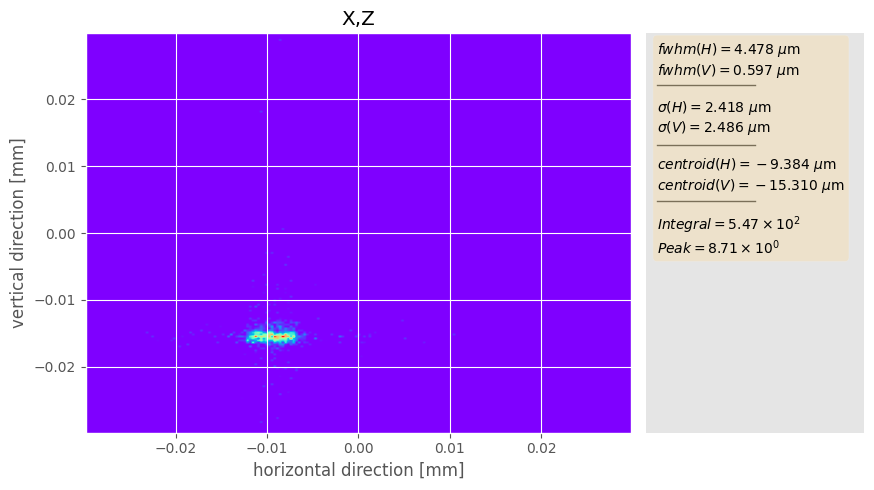

[0.024936245994463, 0.003247825810160928] 19.029819921189212
BeamParameterOutput(parameter_value=0.02507481369712827, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f96bde7e700>, hist=<aps_ai.common.util.common.Histogram object at 0x7f96bdddfca0>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7f9632e70d30>)


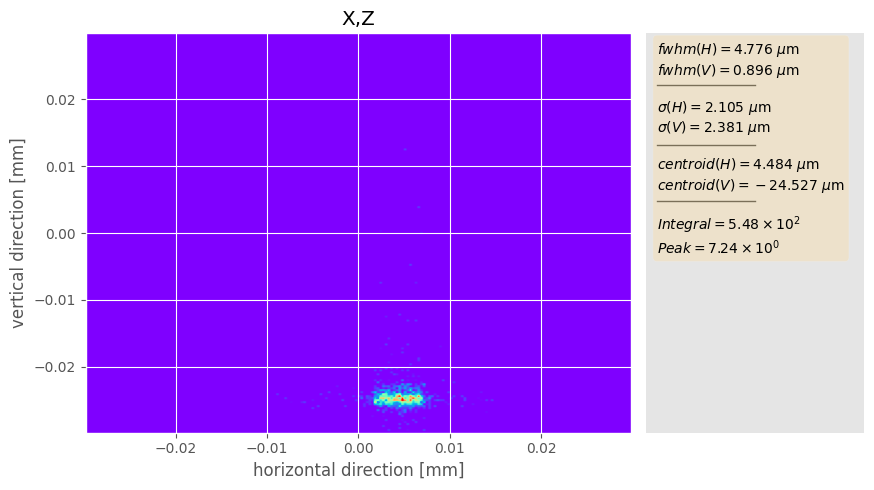

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-58138

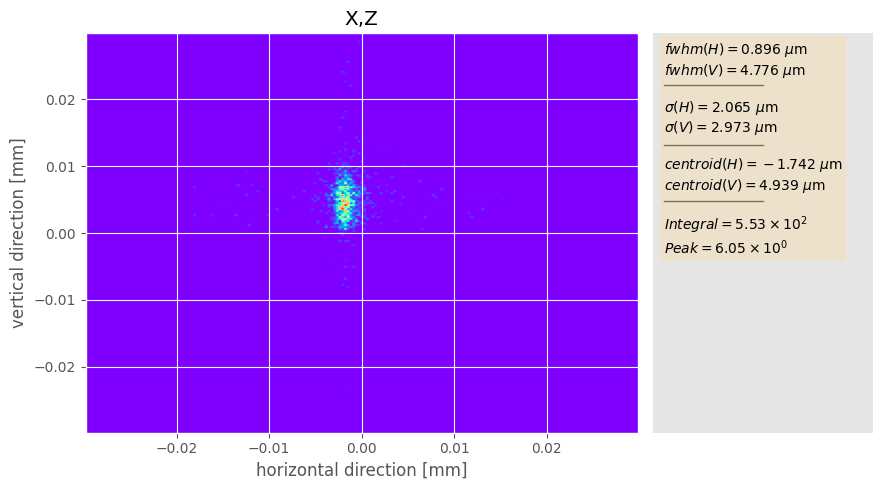

In [128]:
best_absolute_positions = []
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    pos_this = movers.get_absolute_positions(focusing_system, opt_trial.motor_types)
    best_absolute_positions.append(pos_this)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [129]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

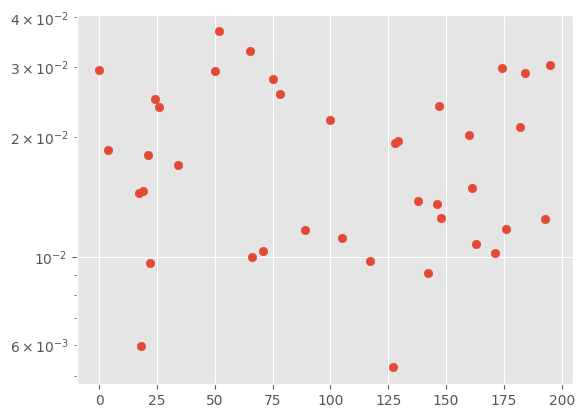

In [130]:
plt.scatter(tnums, centroids)
plt.yscale('log')

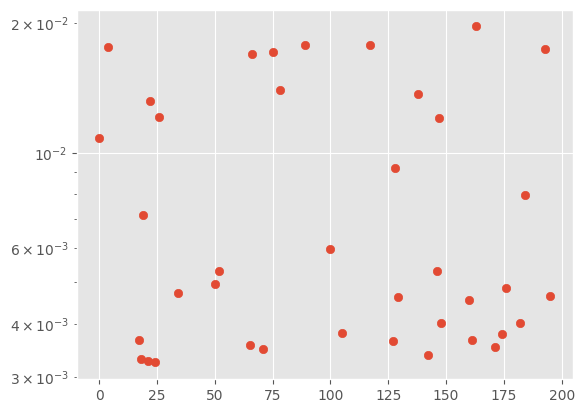

In [131]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

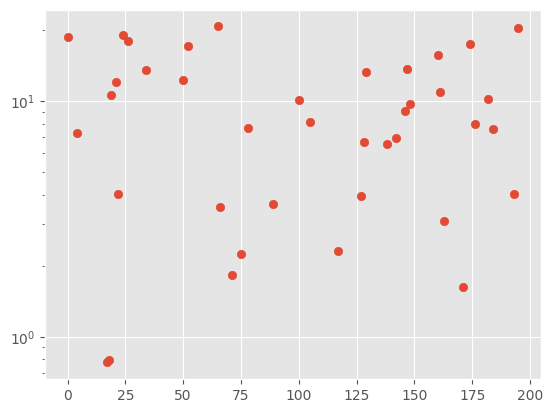

In [132]:
plt.scatter(tnums, wsums)
plt.yscale('log')

In [133]:
np.round(best_absolute_positions, 2)

array([[ 2.4863e+02,  1.6065e+02,  1.5413e+02,  2.2695e+02,  2.9600e+00,
         3.0100e+00, -6.6600e+00, -8.0100e+00],
       [ 2.4863e+02,  1.6065e+02,  1.5413e+02,  2.2695e+02,  2.9800e+00,
         2.9500e+00,  3.2700e+00,  4.4700e+00],
       [ 2.4863e+02,  1.6065e+02,  1.5413e+02,  2.2695e+02,  3.0100e+00,
         2.9500e+00, -4.4400e+00, -4.2300e+00],
       [ 2.0810e+02,  2.0484e+02,  1.4287e+02,  2.3596e+02,  3.0000e+00,
         2.9900e+00, -1.5000e-01,  4.7300e+00]])

In [134]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])

### Different starting structure + increased motor range

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

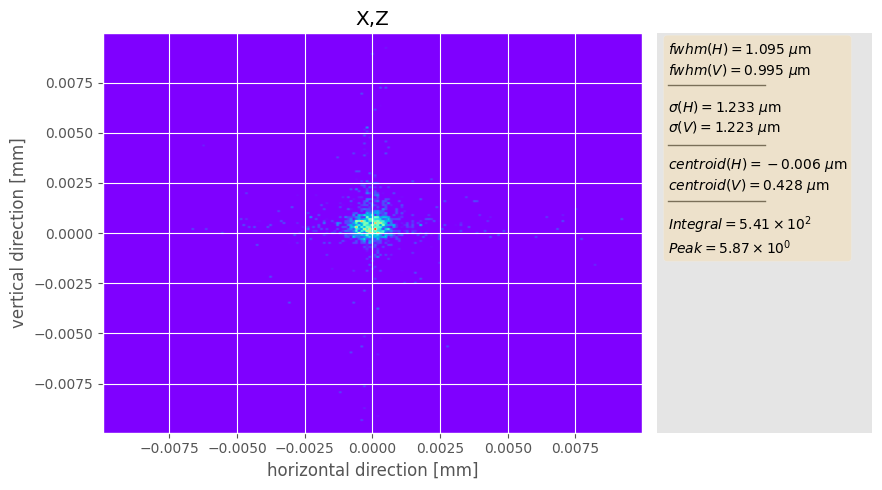

In [147]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [148]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.00041717203996423136, 0.002736531805781683)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

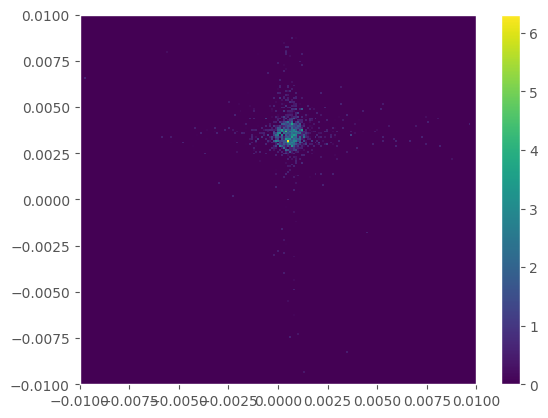

In [149]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    integral_threshold=300,
    nbins=201,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [150]:
hist.data_2D.sum()

541.6701785268823

In [151]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
0.0036457370635303906 0.0027037408069067632


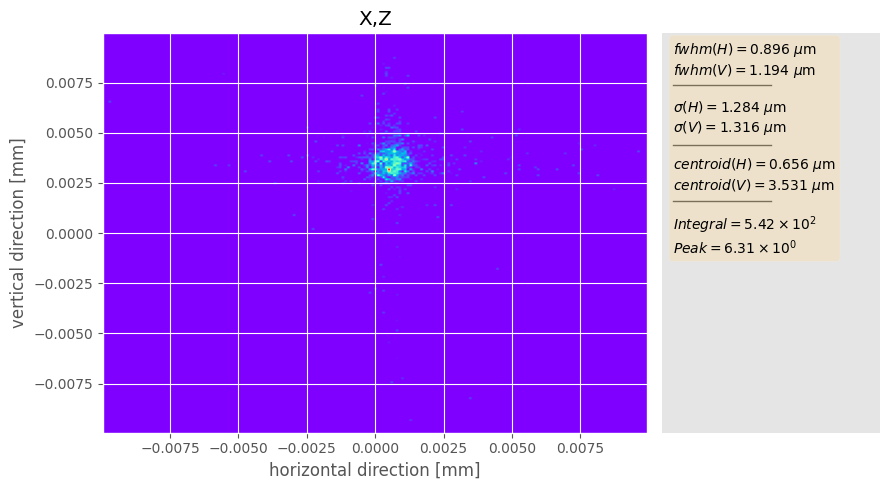

In [152]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [153]:
move_motors_ranges_2 = {k: [v[0] * 2, v[1] * 2] for k,v in move_motors_ranges.items()}

In [154]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.01, 0.01],
                            camera_yrange=[-0.01, 0.01],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

In [155]:
constraints = {"integral_intensity": 500, "centroid":5e-3, "sigma":5e-3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=False,#True,
    use_discrete_space=True,
    moo_thresholds={"centroid": 1e-3, "sigma": 2e-3},
    constraints=constraints,
)

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:300: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler(
[I 2022-10-17 22:08:12,901] A new study created in memory with name: no-name-f2bf8b40-d539-4082-be1d-e14b24fdb41d


In [156]:
opt_trial.trials(20, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:421: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175).
  warnings.warn(
[I 2022-10-17 22:08:17,892] Trial 0 finished with values: [0.003591196890625

In [157]:
opt_trial.study.best_trials

[FrozenTrial(number=10, values=[0.00043202702979899284, 0.0017396415416890475], datetime_start=datetime.datetime(2022, 10, 17, 22, 8, 24, 466019), datetime_complete=datetime.datetime(2022, 10, 17, 22, 8, 26, 777924), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.4000000000000004, 'vkb_4': -0.7999999999999998}, distributions={'hkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'vkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'hkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1), 'vkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1)}, user_attrs={'i

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75345/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


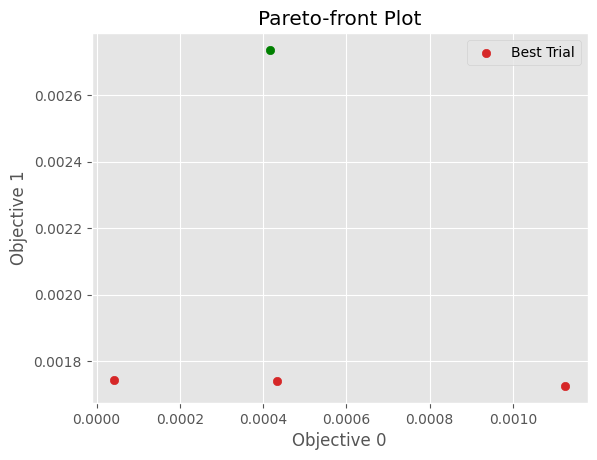

In [158]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [159]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-14.10109860020069 0.587965273989006
-13.151979122265928 0.7715940107357685
-16.4244690011505 0.5390793114962008


[0.00043202702979899284, 0.0017396415416890475] 0.587965273989006


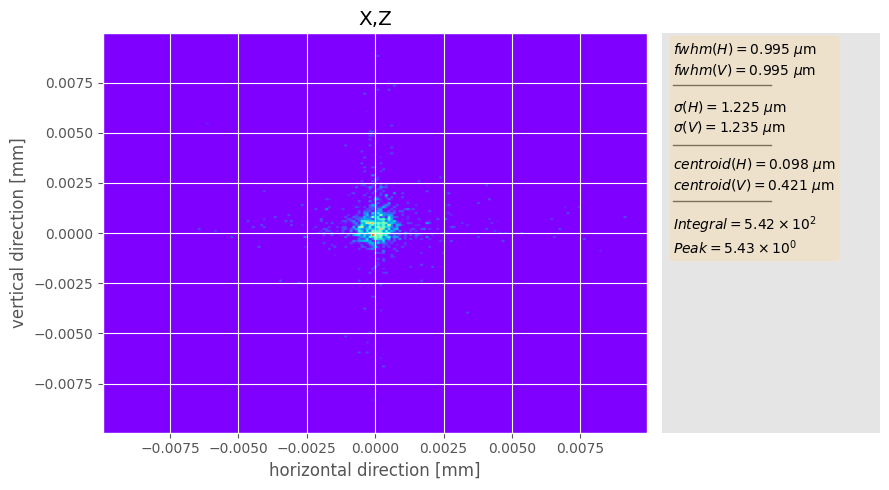

[0.001125139095771311, 0.0017256861974369257] 0.7715940107357685


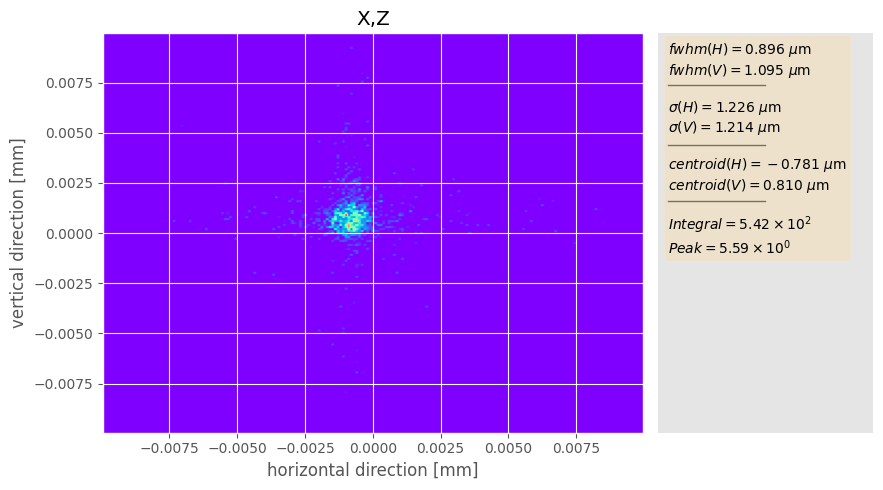

[4.222216804811069e-05, 0.0017434247806688843] 0.5390793114962008


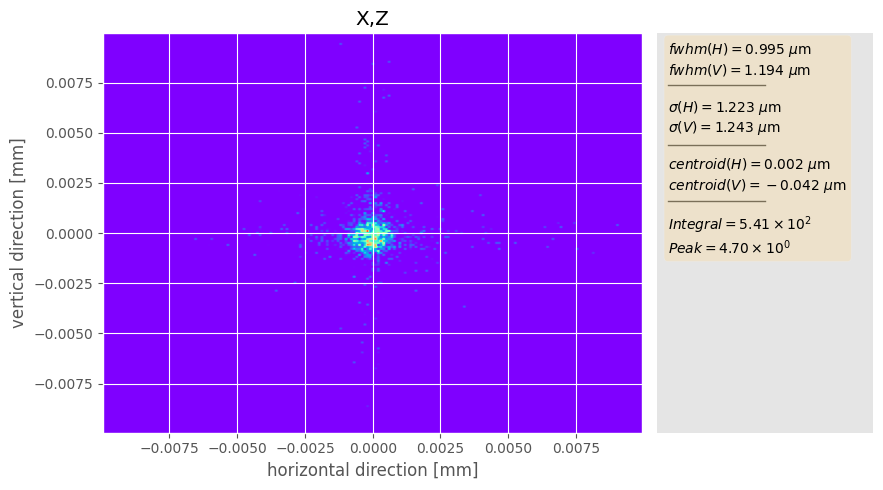

In [160]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [161]:
opt_trial.trials(20)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:11,743] Trial 20 finished with values: [0.0022052266649576803, 0.001820731224761131] and parameters: {'hkb_1': 1.1472000000000007, 'vkb_1': -0.7363999999999997, 'hkb_2': -0.8911999999999995, 'vkb_2': 1.2532000000000005, 'hkb_3': 0.00925, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.4000000000000004, 'vkb_4': -2.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:15,574] Trial 21 finished with values: [0.0023199456611681267, 0.001834959669352522] and parameters: {'hkb_1': -0.8895, 'vkb_1': -0.6688000000000001, 'hkb_2': 0.27890000000000015, 'vkb_2': -0.7953000000000001, 'hkb_3': 0.0022500000000000003, 'vkb_3': -0.0012499999999999994, 'hkb_4': 3.200000000000001, 'vkb_4': -1.6999999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:19,401] Trial 22 finished with values: [0.001314782738524927, 0.0018039766899420131] and parameters: {'hkb_1': 2.7762000000000002, 'vkb_1': 1.8639000000000001, 'hkb_2': 0.03910000000000036, 'vkb_2': -1.101, 'hkb_3': 0.0005000000000000004, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.9000000000000004, 'vkb_4': -0.5999999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:23,661] Trial 23 finished with values: [0.0012643248070477555, 0.001812361439035037] and parameters: {'hkb_1': 2.5594, 'vkb_1': 2.0703000000000005, 'hkb_2': -1.9322999999999997, 'vkb_2': 1.8613, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00475, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.09999999999999964}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:27,075] Trial 24 finished with values: [0.0009400651361345877, 0.0017482039625744043] and parameters: {'hkb_1': -2.2483, 'vkb_1': 1.388, 'hkb_2': 0.6763000000000003, 'vkb_2': 3.4062, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00475, 'hkb_4': 1.5, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:30,638] Trial 25 finished with values: [0.000927326513387335, 0.001740619132490253] and parameters: {'hkb_1': 2.7730000000000006, 'vkb_1': 2.3422, 'hkb_2': 1.3005000000000004, 'vkb_2': 4.937800000000001, 'hkb_3': 0.00925, 'vkb_3': -0.00475, 'hkb_4': 1.8000000000000007, 'vkb_4': -0.8999999999999995}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:34,392] Trial 26 finished with values: [0.0018300757320972474, 0.0018220989545036379] and parameters: {'hkb_1': 0.2528000000000006, 'vkb_1': 4.4937000000000005, 'hkb_2': 2.4843, 'vkb_2': -0.18799999999999972, 'hkb_3': 0.00925, 'vkb_3': -0.003, 'hkb_4': 1.2000000000000002, 'vkb_4': -1.0999999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:38,038] Trial 27 finished with values: [0.0007018879808766102, 0.0017670175401012708] and parameters: {'hkb_1': 4.4914000000000005, 'vkb_1': 2.9279, 'hkb_2': -0.19320000000000004, 'vkb_2': 3.714500000000001, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:41,501] Trial 28 finished with values: [0.0020939625120553083, 0.0018401436643029382] and parameters: {'hkb_1': -2.4772, 'vkb_1': 3.5062999999999995, 'hkb_2': 0.1034000000000006, 'vkb_2': 4.538600000000001, 'hkb_3': 0.004, 'vkb_3': -0.00825, 'hkb_4': 1.6000000000000005, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:45,052] Trial 29 finished with values: [0.00038844259897598515, 0.0017279508105304665] and parameters: {'hkb_1': 0.6790000000000003, 'vkb_1': 0.14310000000000045, 'hkb_2': -0.7965999999999998, 'vkb_2': 2.2817000000000007, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.7000000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:48,724] Trial 30 finished with values: [0.0014513598076376867, 0.001886775824610826] and parameters: {'hkb_1': 1.9097, 'vkb_1': 3.3642000000000003, 'hkb_2': 0.1463000000000001, 'vkb_2': 2.6503000000000005, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00825, 'hkb_4': 1.1000000000000005, 'vkb_4': -0.1999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:52,429] Trial 31 finished with values: [0.0007268710571396884, 0.0017520321022761567] and parameters: {'hkb_1': 2.8404000000000007, 'vkb_1': 2.2966000000000006, 'hkb_2': -0.2629999999999999, 'vkb_2': 1.2524000000000006, 'hkb_3': 0.00575, 'vkb_3': -0.006500000000000001, 'hkb_4': 2.6000000000000005, 'vkb_4': -0.1999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:55,994] Trial 32 finished with values: [0.0011392921130496249, 0.001778591086135265] and parameters: {'hkb_1': -2.9365, 'vkb_1': 0.18909999999999982, 'hkb_2': 2.6484000000000005, 'vkb_2': 2.9571000000000005, 'hkb_3': 0.00575, 'vkb_3': -0.003, 'hkb_4': 1.8000000000000007, 'vkb_4': -0.7999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:59,907] Trial 33 finished with values: [0.0012861534434538615, 0.001800911327061516] and parameters: {'hkb_1': -1.2386, 'vkb_1': 0.6276000000000002, 'hkb_2': 1.3567, 'vkb_2': 3.4945000000000004, 'hkb_3': 0.0022500000000000003, 'vkb_3': -0.006500000000000001, 'hkb_4': 2.3000000000000007, 'vkb_4': -0.7000000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:03,402] Trial 34 finished with values: [0.0009142041626542534, 0.001739723731946215] and parameters: {'hkb_1': 0.8382000000000005, 'vkb_1': 2.7092, 'hkb_2': 2.2637, 'vkb_2': 4.5908, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.003, 'hkb_4': 1.7000000000000002, 'vkb_4': -1.2999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:06,868] Trial 35 finished with values: [0.0008598148408121332, 0.0017710609843576597] and parameters: {'hkb_1': 3.2795000000000005, 'vkb_1': 3.236700000000001, 'hkb_2': 0.8233000000000006, 'vkb_2': 2.2228000000000003, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.006500000000000001, 'hkb_4': 3.0, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:10,660] Trial 36 finished with values: [0.0010906233080353882, 0.0017607614054138464] and parameters: {'hkb_1': 0.7509000000000006, 'vkb_1': 4.0692, 'hkb_2': 2.5474000000000006, 'vkb_2': 4.9452, 'hkb_3': 0.0005000000000000004, 'vkb_3': -0.003, 'hkb_4': 1.7000000000000002, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:14,496] Trial 37 finished with values: [0.0004245507466977374, 0.0017782936323595502] and parameters: {'hkb_1': -2.2603999999999997, 'vkb_1': 1.3959000000000001, 'hkb_2': 1.9503000000000004, 'vkb_2': 1.4780000000000006, 'hkb_3': -0.0012499999999999994, 'vkb_3': -0.003, 'hkb_4': 0.7000000000000002, 'vkb_4': -2.1999999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:17,954] Trial 38 finished with values: [0.0014205399415748003, 0.0018102235142417585] and parameters: {'hkb_1': 1.2283, 'vkb_1': 3.7634000000000007, 'hkb_2': 0.8696000000000002, 'vkb_2': 4.848600000000001, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.9000000000000004, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:21,288] Trial 39 finished with values: [0.0009370981482244066, 0.0017319567657995362] and parameters: {'hkb_1': 1.8671000000000006, 'vkb_1': 3.3221000000000007, 'hkb_2': 2.2189000000000005, 'vkb_2': 1.5054000000000007, 'hkb_3': 0.00575, 'vkb_3': -0.00475, 'hkb_4': 2.4000000000000004, 'vkb_4': -2.0}. 


In [162]:
opt_trial.study.best_trials

[FrozenTrial(number=17, values=[0.001125139095771311, 0.0017256861974369257], datetime_start=datetime.datetime(2022, 10, 17, 22, 8, 43, 828900), datetime_complete=datetime.datetime(2022, 10, 17, 22, 8, 46, 723714), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.00575, 'vkb_3': -0.003, 'hkb_4': 2.7, 'vkb_4': -1.1999999999999997}, distributions={'hkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'vkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'hkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1), 'vkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1)}, user_attrs={'integral_intensity

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75345/789799494.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)


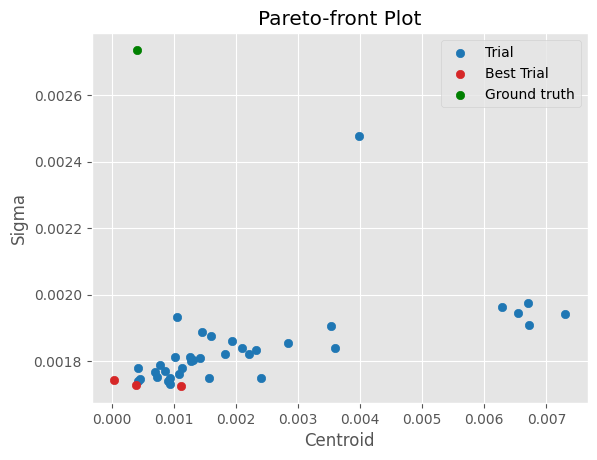

In [163]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [164]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-13.151979122265928
-16.4244690011505
-14.214184224589943


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

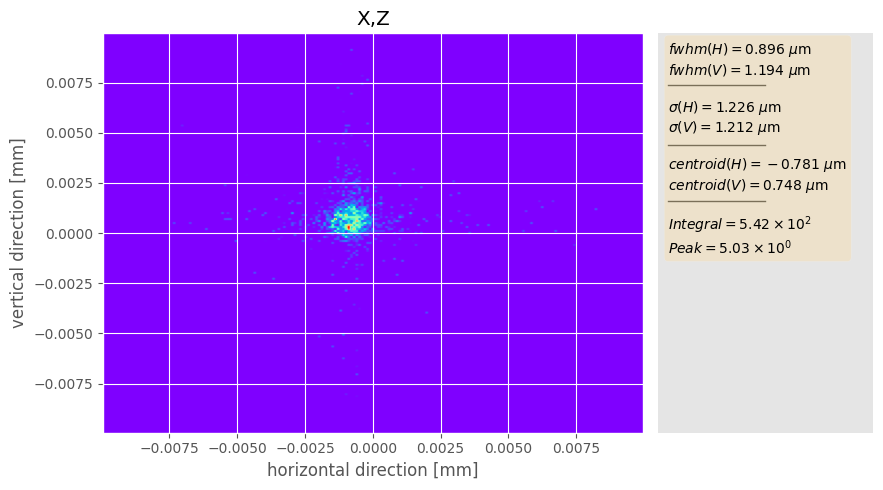

[4.222216804811069e-05, 0.0017434247806688843] 0.5390793114962008
BeamParameterOutput(parameter_value=9.816945689093482e-05, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7fe8ebefc790>, hist=<aps_ai.common.util.common.Histogram object at 0x7fe8789d99d0>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7fe8882569a0>)


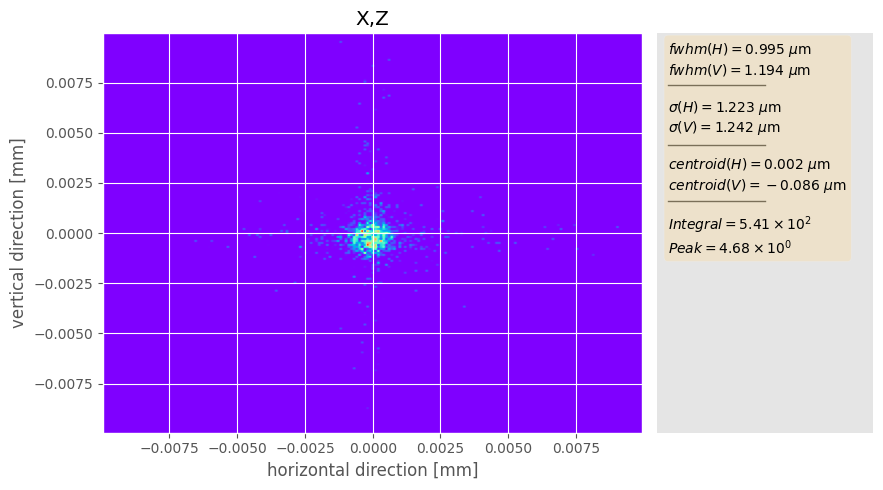

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

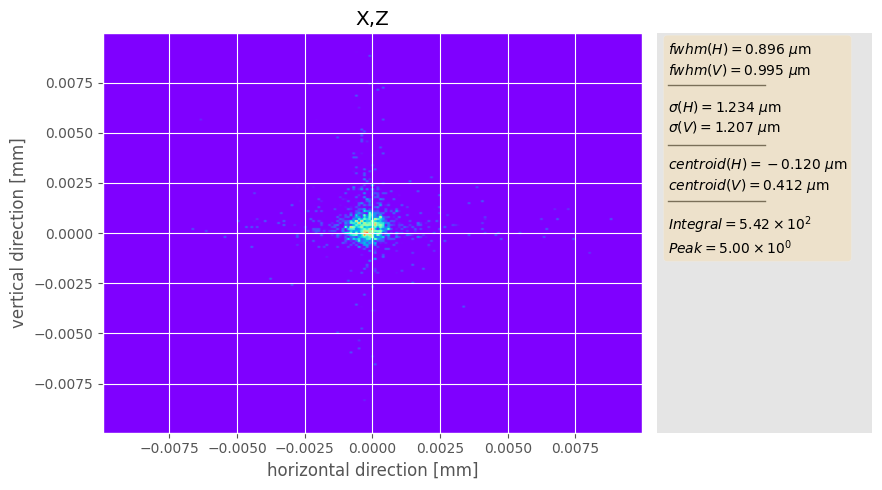

In [165]:
best_absolute_positions = []
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    pos_this = movers.get_absolute_positions(focusing_system, opt_trial.motor_types)
    best_absolute_positions.append(pos_this)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [166]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

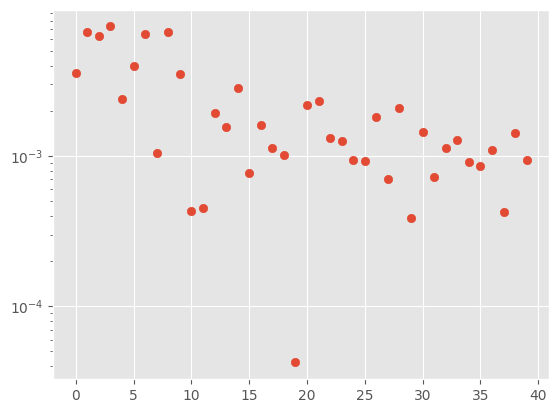

In [167]:
plt.scatter(tnums, centroids)
plt.yscale('log')

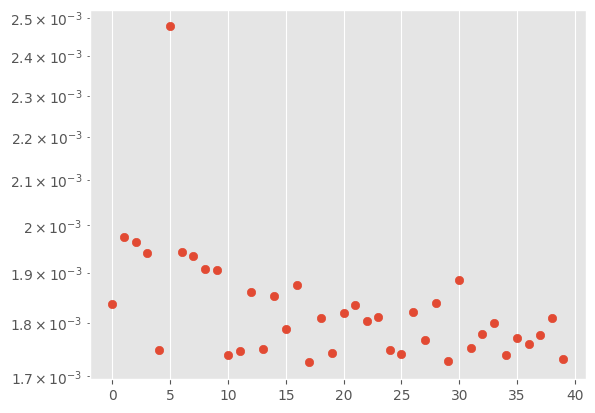

In [168]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

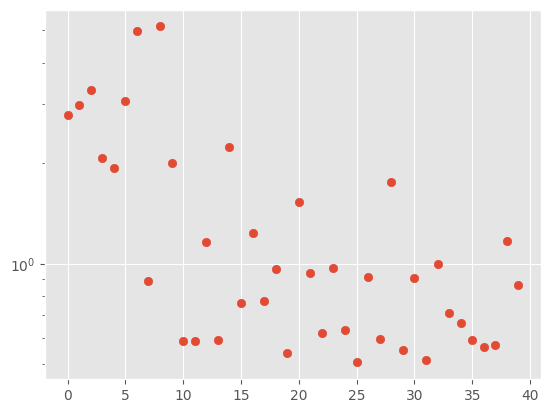

In [169]:
plt.scatter(tnums, wsums)
plt.yscale('log')

In [170]:
np.round(best_absolute_positions, 2)

array([[216.64, 143.  , 115.19, 227.16,   3.  ,   2.99,   0.81,   2.6 ],
       [216.64, 143.  , 115.19, 227.16,   3.  ,   2.99,  -0.39,   3.5 ],
       [217.32, 143.14, 114.39, 229.45,   3.  ,   2.99,  -0.29,   3.1 ]])

In [171]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])